<a href="https://colab.research.google.com/github/DCEG-workshops/statistical_genetics_workshop/blob/main/src/02_qc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up a few things

In [2]:
#load python libraries
import os

In [3]:
#load R magic
%load_ext rpy2.ipython

We want to mount the google drive for the data neeed for this workshop. Please open this ![link](https://drive.google.com/drive/folders/1rui3w4tok2Z7EhtMbz6PobeC_fDxTw7G?usp=sharing) with your Google drive and find the "statgen_workshop" folder under "Share with me". Then add a shortcut to the folder under "My Drive", as shown in the screenshot.  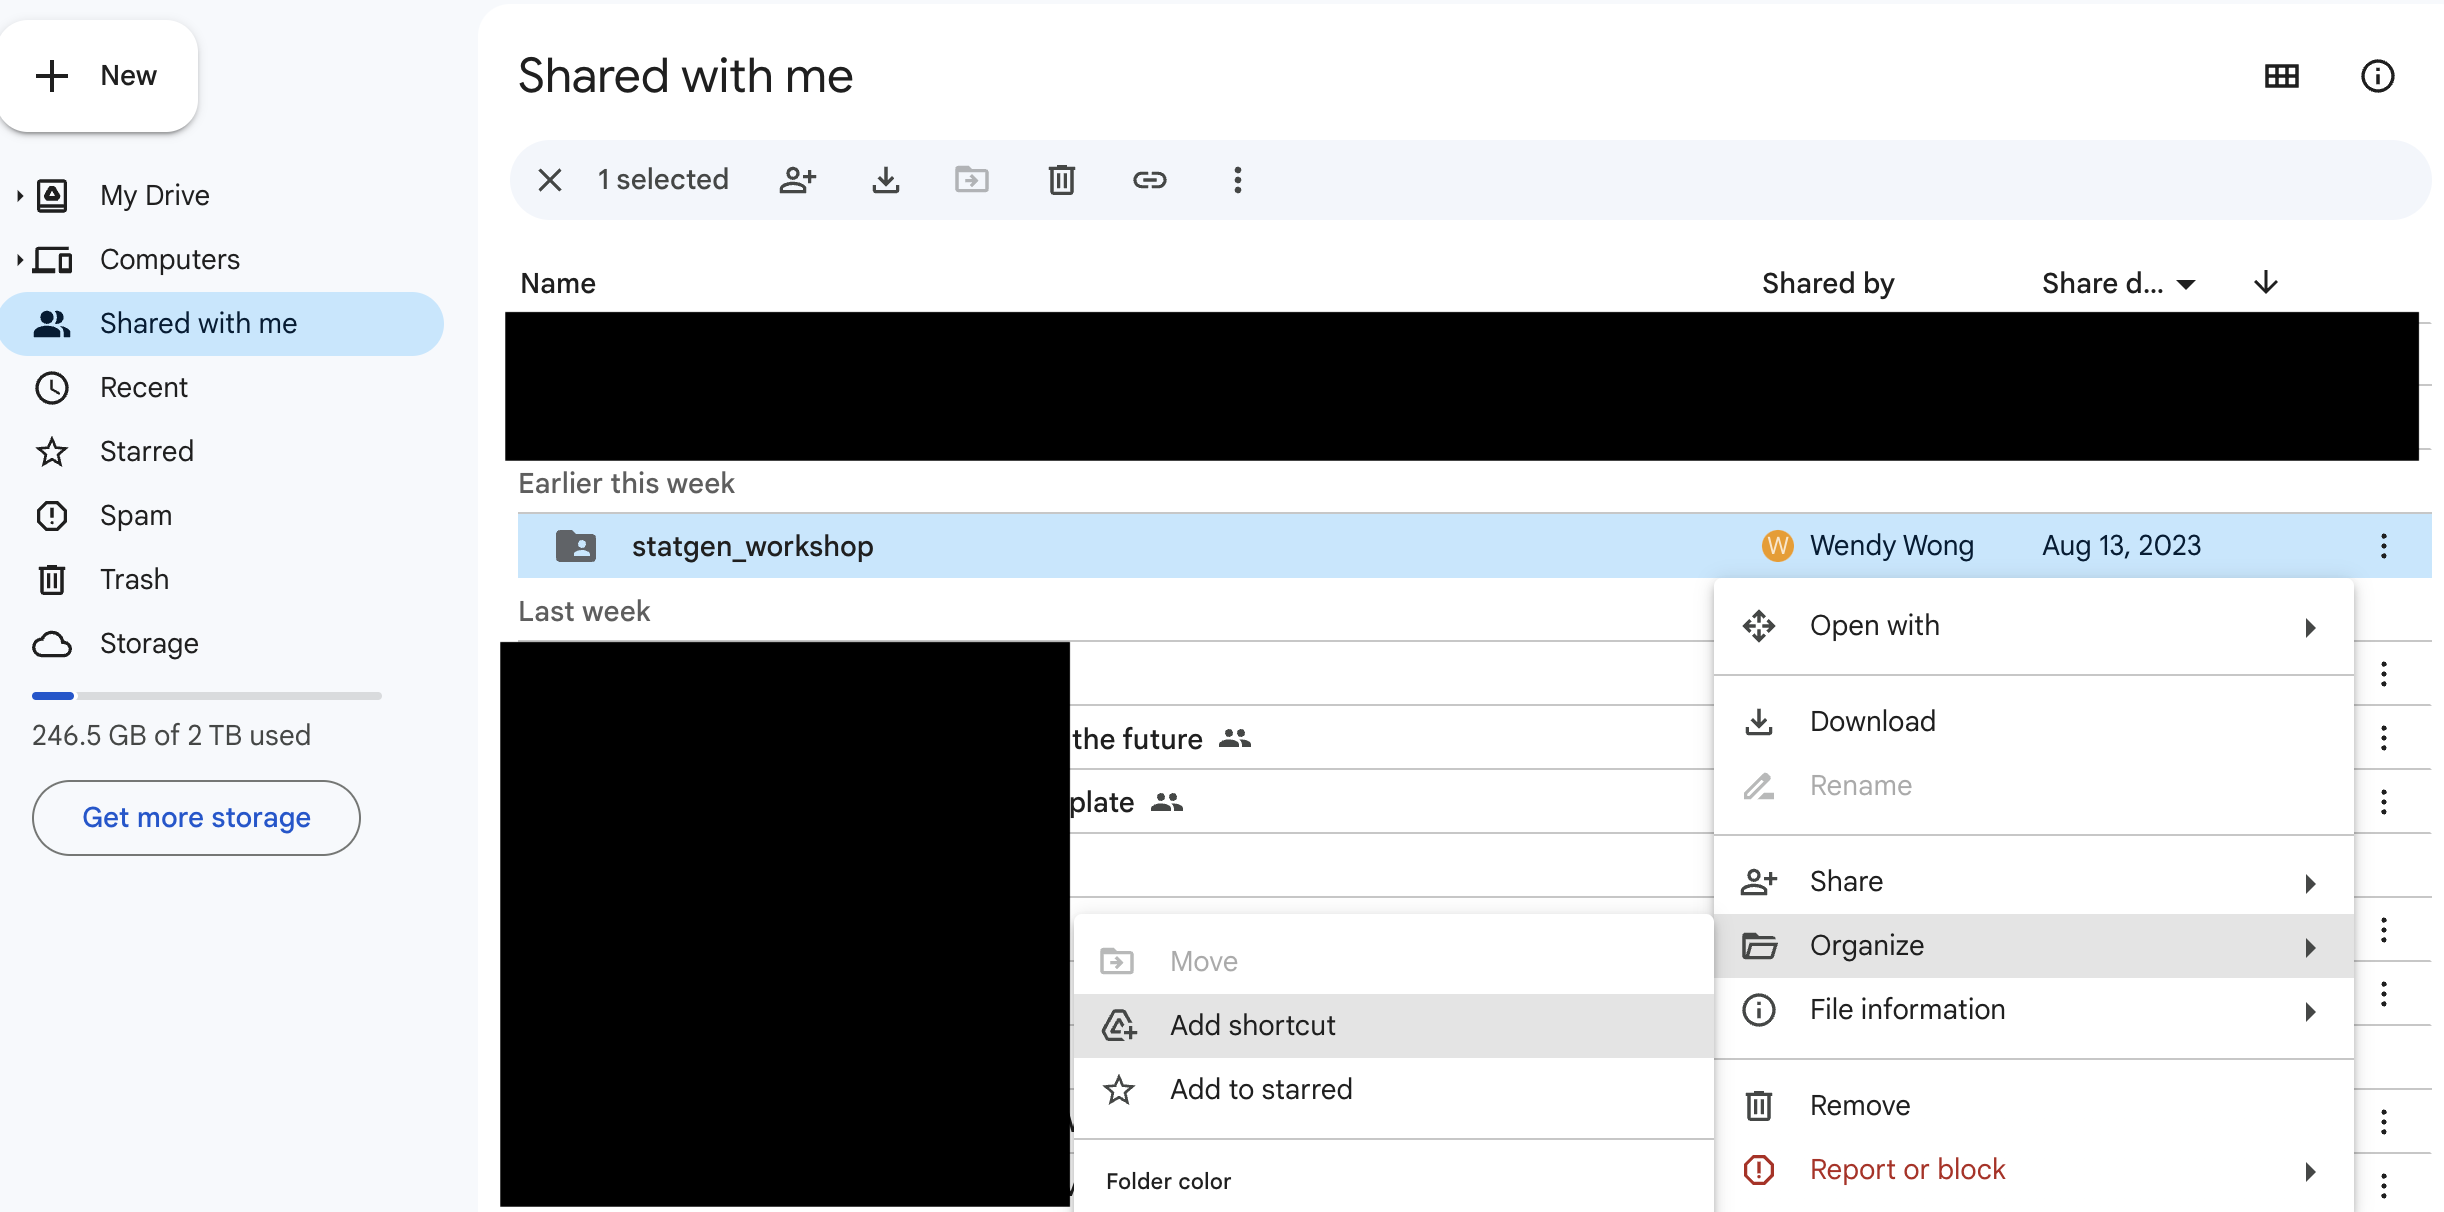

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
#take a look at the files
%ls drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno/

causal_variants.txt  penncath.bim  plink_fix.log  run_plink.sh   sim_pheno.phen
gcta_sim.log         penncath.fam  run_gcta.log   sim_pheno.log
penncath.bed         penncath.log  run_gcta.sh    sim_pheno.par


In [7]:
#take a look at my path
%%bash
echo $PATH
ls /tools/node/bin

/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
node
npm
npx


In [9]:
#download plink1.9
%%bash
curl -o /tools/node/bin/plink.zip https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20230116.zip
cd /tools/node/bin/
unzip plink.zip

Archive:  plink.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8743k  100 8743k    0     0  9101k      0 --:--:-- --:--:-- --:--:-- 9098k


In [10]:
#see if we can execute plink
%%bash
plink --help --het

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3

--het ['small-sample'] ['gz']
--ibc
  Estimate inbreeding coefficients.  --het reports method-of-moments
  estimates, while --ibc calculates all three values described in Yang J, Lee
  SH, Goddard ME and Visscher PM (2011) GCTA: A Tool for Genome-wide Complex
  Trait Analysis.  (That paper also describes the relationship matrix
  computation we reimplement.)
  * These functions require decent MAF estimates.  If there are very few
    samples in your immediate fileset, --read-freq is practically mandatory
    since imputed MAFs are wildly inaccurate in that case.
  * They also assume the marker set is in approximate linkage equilibrium.
  * By default, --het omits the n/(n-1) multiplier in Nei's expected
    homozygosity formula.  The 'small-sample' modifier causes it to be
    included, while forcing --het to use MAFs imputed fro

In [11]:
#set variables
input_dir="drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno"
reference_dir="drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref/"
analysis_dir=os.getcwd() + "/analysis/"
os.environ['input_dir']=input_dir
os.environ['analysis_dir']=analysis_dir
os.environ['reference_dir']=reference_dir

In [12]:
#create analysis dir, this is going to be ephemeral and sits on the hosted runtime environment
%%bash
mkdir -p ${analysis_dir}

load R libraries

In [13]:
%%R -i input_dir -i analysis_dir
library(tidyverse)
library(data.table)
library(glue)

print(input_dir)
print(analysis_dir)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘data.table’



    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year



    between, first, last



    transpose




[1] "drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno"
[1] "/content/analysis/"


# QC steps

Calculate call rates for flagging poorly called SNPs and individuals
the penncath.lmss file shows the per variant missingness and the penncath.imiss file shows the per individual missingness

In [14]:
%%bash -s "$analysis_dir" "$input_dir"
plink --bfile ${input_dir}/penncath --missing --out ${analysis_dir}/penncath

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.log.
Options in effect:
  --bfile drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno/penncath
  --missing
  --out /content/analysis//penncath

12982 MB RAM detected; reserving 6491 MB for main workspace.
861473 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

let's look at the distribution of per variant call rates   

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


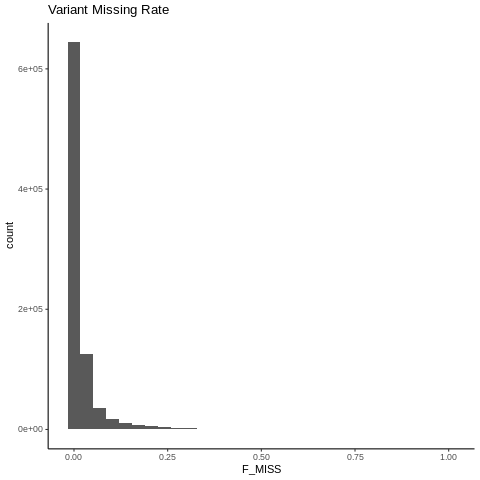

In [15]:
%%R
variant_miss <- fread(glue(analysis_dir, "penncath.lmiss"))

variant_miss %>% ggplot( aes(x = F_MISS)) +
  geom_histogram() +
  labs(title = "Variant Missing Rate") +
  theme_classic()

If we want to filter out the variants with missing rate >0.01, how many are there?

In [16]:
%%R
variant_miss %>% mutate(missing_rate_gt0.01 = if_else(F_MISS > 0.01, "Yes", "No")) %>%
                 group_by(missing_rate_gt0.01) %>%
                 tally()

# A tibble: 2 × 2
  missing_rate_gt0.01      n
  <chr>                <int>
1 No                  569723
2 Yes                 291750


We will use plink to filter out the 291750 SNPs and

In [17]:
%%bash
plink --bfile ${input_dir}/penncath --geno 0.01 --make-bed --out ${analysis_dir}/penncath.geno0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.log.
Options in effect:
  --bfile drive/MyDrive/statgen_workshop/data/workshop1/inputs/penncath_withPheno/penncath
  --geno 0.01
  --make-bed
  --out /content/analysis//penncath.geno0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
861473 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45

After removing the 291750 SNPs, we will recalculate the missing rate for the samples

In [18]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01 --missing --out ${analysis_dir}/penncath.geno0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01
  --missing
  --out /content/analysis//penncath.geno0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1401 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%5

take a look at per sample missing rate

In [19]:
%%R
sample_miss <- fread(glue(analysis_dir, "penncath.geno0.01.imiss"))
sample_miss %>% mutate(missing_rate_gt0.01 = if_else(F_MISS > 0.01, "Yes", "No")) %>%
                 group_by(missing_rate_gt0.01) %>%
                 tally()

# A tibble: 2 × 2
  missing_rate_gt0.01     n
  <chr>               <int>
1 No                   1380
2 Yes                    21


we will remove the 21 samples with >0.01 missing rate

In [20]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01 --mind 0.01 --make-bed --out ${analysis_dir}/penncath.geno0.01.mind0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01
  --make-bed
  --mind 0.01
  --out /content/analysis//penncath.geno0.01.mind0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1401 people (937 males, 464 females) loaded from .fam.
933 phenotype values loaded from .fam.
21 people removed due to missing genotype data (--mind).
IDs written to /content/analysis//penncath.geno0.01.mind0.01.irem .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%

Next, we look at the HWE statistics

In [21]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 --hardy --out ${analysis_dir}/penncath.geno0.01.mind0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --hardy
  --out /content/analysis//penncath.geno0.01.mind0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

Examine HWE statistics

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


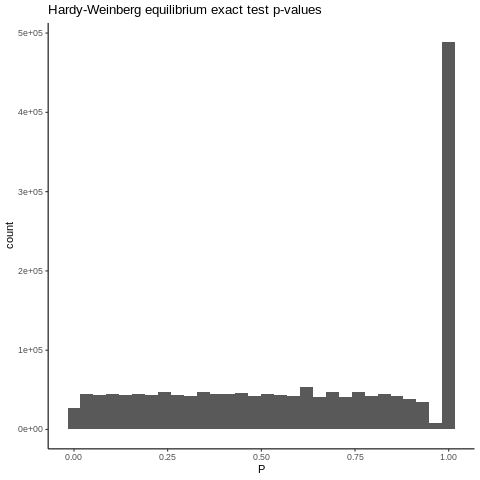

In [22]:
%%R
hwe_stat <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.hwe"))


hwe_stat %>% ggplot( aes(x = P)) +
  geom_histogram() +
  labs(title = "Hardy-Weinberg equilibrium exact test p-values") +
  theme_classic()

How many markers are with P<1e-8?
TODO: what threshold to use????

In [23]:
%%R
hwe_stat %>% mutate(hwe_stat_lessThan1e_8 = if_else(P < 1e-8, TRUE, FALSE)) %>%
                 group_by(hwe_stat_lessThan1e_8) %>%
                 tally()

# A tibble: 2 × 2
  hwe_stat_lessThan1e_8       n
  <lgl>                   <int>
1 FALSE                 1708443
2 TRUE                      726


LD pruning

In [24]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 --indep-pairwise 50 5 0.3 --out ${analysis_dir}/penncath.geno0.01.mind0.01

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --indep-pairwise 50 5 0.3
  --out /content/analysis//penncath.geno0.01.mind0.01

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%

Relatedness check

In [25]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 \
      --extract ${analysis_dir}/penncath.geno0.01.mind0.01.prune.in \
      --genome --min 0.05 --out ${analysis_dir}/penncath.geno0.01.mind0.01.LD0.3

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.LD0.3.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --extract /content/analysis//penncath.geno0.01.mind0.01.prune.in
  --genome
  --min 0.05
  --out /content/analysis//penncath.geno0.01.mind0.01.LD0.3

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--extract: 176206 variants remaining.
Using up to 2 threads (change this with --threads).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%

Check pairs of samples with PI_HAT>0.05, maximum PI_HAT is 0.1745, no duplicates nor first degree relatives
TODO: do we want to remove any samples?

In [26]:
%%R
ibd <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.LD0.3.genome"))
summary(ibd$PI_HAT)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05000 0.05225 0.05395 0.06848 0.05962 0.17450 


run Heterozygocity

In [27]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 --het \
      --extract ${analysis_dir}/penncath.geno0.01.mind0.01.prune.in \
      --out ${analysis_dir}/penncath.geno0.01.mind0.01.LD0.3

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.LD0.3.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --extract /content/analysis//penncath.geno0.01.mind0.01.prune.in
  --het
  --out /content/analysis//penncath.geno0.01.mind0.01.LD0.3

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--extract: 176206 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%

look at the heterozygocity of individuals, find individuals with heterozygocity +- 3 s.d.
TODO: remove any one?

In [28]:
%%R
heterozygocity <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.LD0.3.het"))

heterozygocity %>% mutate (het_rate = (`N(NM)` - `O(HOM)`) / `N(NM)` ) %>%
                   ggplot( aes(x = het_rate)) +
                   geom_histogram() +
                   labs(title = "Heterozygocity") +
                   theme_classic()

heterozygocity %>% mutate (het_rate = (`N(NM)` - `O(HOM)`) / `N(NM)` ) %>%
                   filter (het_rate < mean(het_rate)-3*sd(het_rate) |
                          het_rate > mean(het_rate)+3*sd(het_rate))

      FID IID O(HOM) E(HOM)  N(NM)        F  het_rate
 1: 10063   1 135070 136300 175538 -0.03105 0.2305370
 2: 10312   1 134247 135600 174626 -0.03475 0.2312313
 3: 10386   1 133933 135400 174490 -0.03681 0.2324317
 4: 10420   1 133492 135300 174257 -0.04522 0.2339361
 5: 10675   1 133848 135300 174286 -0.03779 0.2320209
 6: 10986   1 137896 136400 175638  0.03909 0.2148852
 7: 11232   1 135362 136600 175908 -0.03114 0.2304955
 8: 11310   1 134242 135500 174565 -0.03295 0.2309913
 9: 11315   1 135452 136700 176066 -0.03182 0.2306749
10: 11455   1 138068 136600 175997  0.03639 0.2155094
11: 11594   1 133948 135300 174422 -0.03472 0.2320464


use plink for simple pca

In [29]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01  \
      --extract ${analysis_dir}/penncath.geno0.01.mind0.01.prune.in \
      --maf 0.05 --pca  --out ${analysis_dir}/penncath.geno0.01.mind0.01.LD0.3

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.LD0.3.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --extract /content/analysis//penncath.geno0.01.mind0.01.prune.in
  --maf 0.05
  --out /content/analysis//penncath.geno0.01.mind0.01.LD0.3
  --pca

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--extract: 176206 variants remaining.
Using up to 2 threads (change this with --threads).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30

plot PCA

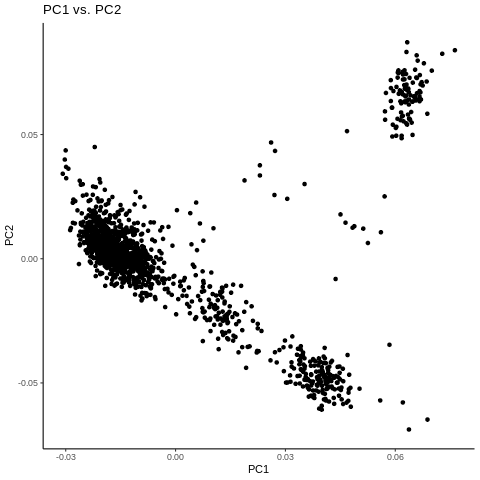

In [30]:
%%R
pca <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.LD0.3.eigenvec"))

pca %>% rename (PC1 = V3, PC2 = V4) %>%
        ggplot(aes(x = PC1, y = PC2)) +
        geom_point() +
        labs(title = "PC1 vs. PC2") + theme_classic()

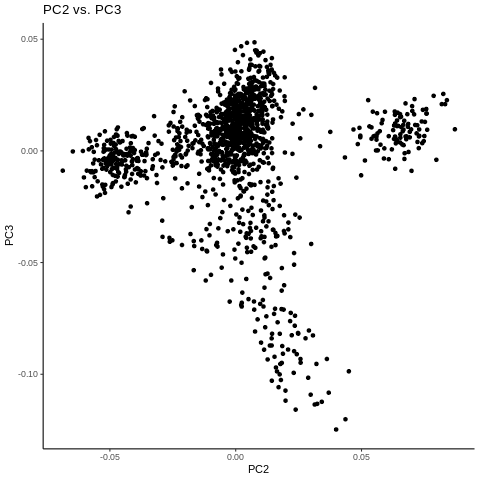

In [31]:
%%R
pca %>% rename (PC2 = V4, PC3 = V5) %>%
        ggplot(aes(x = PC2, y = PC3)) +
        geom_point() +
        labs(title = "PC2 vs. PC3") + theme_classic()

we will use 1000 genomes data as reference to take a look at the ancestries of the samples.

In [32]:
#the 1000 genomes phase 3 data is in the google drive
%ls $reference_dir/

all_pops_1kgenomes_markersForPCA.bed  all_pops_1kgenomes_markersForPCA.fam
all_pops_1kgenomes_markersForPCA.bim


AKT is a ancestry and kinship toolkit developed at Illumina. It's mainly useful for analyzing WGS and WGS VCF files. We will use some of its data files here for our analysis. Here we will clone the repo.

In [33]:
%%bash
git clone https://github.com/Illumina/akt.git
ls akt/data/

1000G.pca_to_admix
AFR.samples
AMR.samples
EAS.samples
EUR.samples
gen_admix.sh
integrated_call_samples_v3.20130502.ALL.panel
README.md
SAS.samples
wes.1000G.phase3.pca
wes.grch37.vcf.gz
wes.grch37.vcf.gz.tbi
wes.grch38.vcf.gz
wes.grch38.vcf.gz.tbi
wes.hg19.vcf.gz
wes.hg19.vcf.gz.tbi
wes.hg38.vcf.gz
wes.hg38.vcf.gz.tbi
wgs.1000G.phase3.pca
wgs.grch37.vcf.gz
wgs.grch37.vcf.gz.tbi
wgs.grch38.vcf.gz
wgs.grch38.vcf.gz.tbi
wgs.hg19.vcf.gz
wgs.hg19.vcf.gz.tbi
wgs.hg38.vcf.gz
wgs.hg38.vcf.gz.tbi


Cloning into 'akt'...


Normally, we will merge with the full set of 1000 genomes data, but the size of that is over 12GB, we have subseted to the list of markers to be used for PCA here.  

In [35]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 \
      --bmerge ${reference_dir}/all_pops_1kgenomes_markersForPCA.bed \
      ${reference_dir}/all_pops_1kgenomes_markersForPCA.bim \
      ${reference_dir}/all_pops_1kgenomes_markersForPCA.fam \
      --make-bed --out ${analysis_dir}/penncath.geno0.01.mind0.01.merge1kgenomes

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --bmerge drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.bed drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.bim drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.fam
  --make-bed
  --out /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes

12982 MB RAM detected; reserving 6491 MB for main workspace.
1380 people loaded from /content/analysis//penncath.geno0.01.mind0.01.fam.
2504 people to be merged from
drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.fam.
Of these, 2504 are new, while 0 are present in th

Error: 5692 variants with 3+ alleles present.
* If you believe this is due to strand inconsistency, try --flip with
  /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes-merge.missnp.
  (Warning: if this seems to work, strand errors involving SNPs with A/T or C/G
  alleles probably remain in your data.  If LD between nearby SNPs is high,
  --flip-scan should detect them.)
* If you are dealing with genuine multiallelic variants, we recommend exporting
  that subset of the data to VCF (via e.g. '--recode vcf'), merging with
  another tool/script, and then importing the result; PLINK is not yet suited
  to handling them.
See https://www.cog-genomics.org/plink/1.9/data#merge3 for more discussion.


CalledProcessError: ignored

about half of the markers need to be flipped. Usually, we want to use strand tools like this one (https://www.well.ox.ac.uk/~wrayner/tools/) to flip them to top strand/reference strand. But here, we will just try to see if flipping our mismatched markers can increase the number of matched markers

In [38]:
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01 \
      --flip ${analysis_dir}/penncath.geno0.01.mind0.01.merge1kgenomes-merge.missnp \
      --make-bed \
      --out ${analysis_dir}/penncath.geno0.01.mind0.01_flipSNPs

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01_flipSNPs.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01
  --flip /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes-merge.missnp
  --make-bed
  --out /content/analysis//penncath.geno0.01.mind0.01_flipSNPs

12982 MB RAM detected; reserving 6491 MB for main workspace.
569723 variants loaded from .bim file.
1380 people (922 males, 458 females) loaded from .fam.
918 phenotype values loaded from .fam.
--flip: 5692 SNPs flipped.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1380 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%2

In [40]:
#merge again
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01_flipSNPs \
      --bmerge ${reference_dir}/all_pops_1kgenomes_markersForPCA.bed \
      ${reference_dir}/all_pops_1kgenomes_markersForPCA.bim \
      ${reference_dir}/all_pops_1kgenomes_markersForPCA.fam \
      --make-bed --out ${analysis_dir}/penncath.geno0.01.mind0.01.merge1kgenomes

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01_flipSNPs
  --bmerge drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.bed drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.bim drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.fam
  --make-bed
  --out /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes

12982 MB RAM detected; reserving 6491 MB for main workspace.
1380 people loaded from
/content/analysis//penncath.geno0.01.mind0.01_flipSNPs.fam.
2504 people to be merged from
drive/MyDrive/statgen_workshop/data/workshop1/inputs/ref//all_pops_1kgenomes_markersForPCA.fam.
Of these, 2504 are new, while 0

In [41]:
#we will subset to the common markers of the two sets for PCA
%%bash
plink --bfile ${analysis_dir}/penncath.geno0.01.mind0.01.merge1kgenomes \
      --geno 0.1 --maf 0.05 --pca \
      --out ${analysis_dir}/penncath.geno0.01.mind0.01.merge1kgenomes

PLINK v1.90b7 64-bit (16 Jan 2023)             www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes.log.
Options in effect:
  --bfile /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes
  --geno 0.1
  --maf 0.05
  --out /content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes
  --pca

12982 MB RAM detected; reserving 6491 MB for main workspace.
575627 variants loaded from .bim file.
3884 people (922 males, 458 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/content/analysis//penncath.geno0.01.mind0.01.merge1kgenomes.nosex .
918 phenotype values loaded from .fam.
Using up to 2 threads (change this with --threads).
Before main variant filters, 3884 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%2

Plotting the PCA data

In [53]:
%%bash
head akt/data/integrated_call_samples_v3.20130502.ALL.panel
tail ${analysis_dir}/penncath.geno0.01.mind0.01.merge1kgenomes.fam

sample	pop	super_pop	gender		
HG00096	GBR	EUR	male
HG00097	GBR	EUR	female
HG00099	GBR	EUR	female
HG00100	GBR	EUR	female
HG00101	GBR	EUR	male
HG00102	GBR	EUR	female
HG00103	GBR	EUR	male
HG00105	GBR	EUR	male
HG00106	GBR	EUR	female
NA21128 NA21128 0 0 0 -9
NA21129 NA21129 0 0 0 -9
NA21130 NA21130 0 0 0 -9
NA21133 NA21133 0 0 0 -9
NA21135 NA21135 0 0 0 -9
NA21137 NA21137 0 0 0 -9
NA21141 NA21141 0 0 0 -9
NA21142 NA21142 0 0 0 -9
NA21143 NA21143 0 0 0 -9
NA21144 NA21144 0 0 0 -9


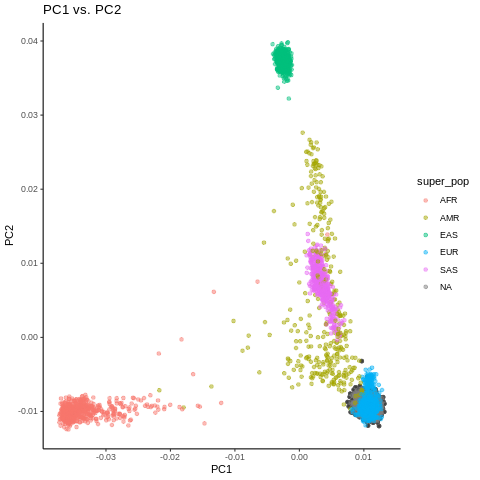

In [76]:
%%R
#-i input_dir -i analysis_dir
pc_with1kgenomes <- fread(glue(analysis_dir, "penncath.geno0.01.mind0.01.merge1kgenomes.eigenvec"))

pop_info_1kgenomes <- fread("akt/data/integrated_call_samples_v3.20130502.ALL.panel")

pc_with1kgenomes<-pc_with1kgenomes %>% rename (PC1 = V3, PC2 = V4, PC3=V5) %>%
         left_join(pop_info_1kgenomes, by = c("V1"="sample"))

ggplot(pc_with1kgenomes, aes(x = PC1, y = PC2, color=super_pop)) +
         geom_point(data=subset(pc_with1kgenomes, is.na(super_pop)), color="black", alpha=1) +
         geom_point(alpha=0.5) +
         labs(title = "PC1 vs. PC2") + theme_classic()

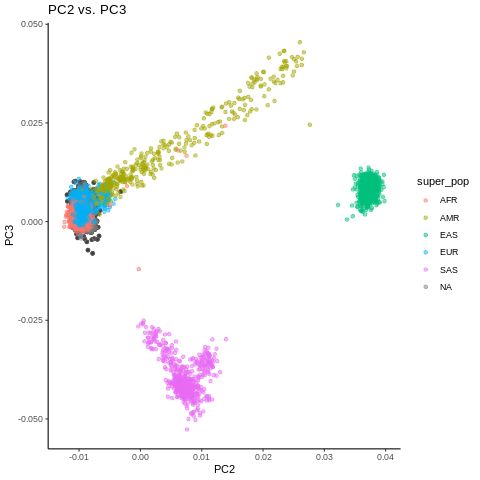

In [77]:
%%R
ggplot(pc_with1kgenomes, aes(x = PC2, y = PC3, color=super_pop)) +
         geom_point(data=subset(pc_with1kgenomes, is.na(super_pop)), color="black", alpha=1) +
         geom_point(alpha=0.5) +
         labs(title = "PC2 vs. PC3") + theme_classic()

# Optional, save your analysis folder
Your current working directory ${analysis_dir} is on the runtime environment and is ephemeral. If you like to save the analysis files to your google drive. Or go to the Files tab and download them to your local drive.

In [ ]:
%%bash
#cp -r ${analysis_dir} /content/drive/

There is revision history of the current notebook under File.
You can also save a copy of the current notebook to GitHub, GitHub Gist or Google Drive under File.